# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Amirhossein Akbari

*SID:* 400104737

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [10]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
from sklearn.manifold import TSNE

## Device

Set device to work with (GPU or CPU)

In [2]:
# !pip install torch torchvision torchaudio

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)

# mean = (0.5, 0.5, 0.5)
# std = (0.5, 0.5, 0.5)

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [7]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

norminv = UnNormalize(mean=mean, std=(0.2, 0.2, 0.2))

In [8]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:01<00:00, 104836491.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_size = int(0.8 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = random_split(initial_trainset, [train_size, val_size])

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

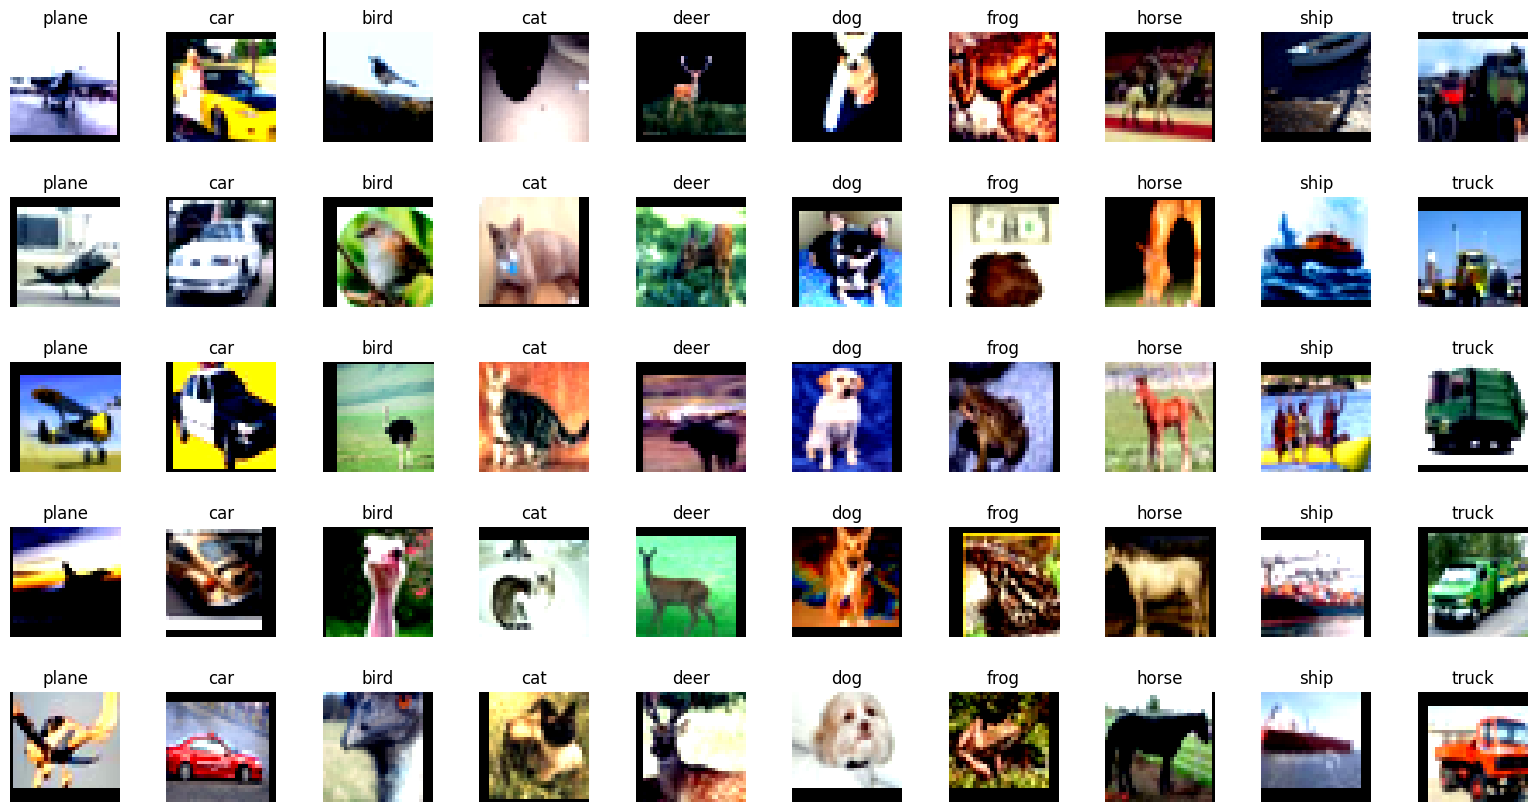

In [ ]:
indices_per_class = {class_name: [] for class_name in classes}
for idx, (_, label) in enumerate(initial_trainset):
    class_name = classes[label]
    indices_per_class[class_name].append(idx)

np.random.seed()
selected_indices_per_class = {class_name: np.random.choice(indices, 5, replace=False) for class_name, indices in indices_per_class.items()}
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for col_idx, (class_name, indices) in enumerate(selected_indices_per_class.items()):
    for row_idx, img_idx in enumerate(indices):
        img, label = initial_trainset[img_idx]
        img = img.permute(1, 2, 0)
        img = img.numpy() * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
        img = np.clip(img, 0, 1)
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].set_title(class_name)
        axes[row_idx, col_idx].axis('off')

plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, downsample_layer=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.activation = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.downsample_layer = downsample_layer

    def forward(self, x):
        shortcut = x if self.downsample_layer is None else self.downsample_layer(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.activation(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, channels_img, num_classes=10):
        super(ResNet18, self).__init__()
        self.initial_channels = 64
        self.initial_conv = nn.Conv2d(channels_img, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_activation = nn.ReLU(inplace=True)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer_block1 = self._build_layer(ResNetBlock, 64, 2, stride=1)
        self.layer_block2 = self._build_layer(ResNetBlock, 128, 2, stride=2)
        self.layer_block3 = self._build_layer(ResNetBlock, 256, 2, stride=2)
        self.layer_block4 = self._build_layer(ResNetBlock, 512, 2, stride=2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)

    def _build_layer(self, block_type, filters, num_blocks, stride):
        downsample = None
        if stride != 1 or self.initial_channels != filters:
            downsample = nn.Sequential(
                nn.Conv2d(self.initial_channels, filters, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(filters),
            )

        layers = [block_type(self.initial_channels, filters, stride, downsample)]
        self.initial_channels = filters
        for _ in range(1, num_blocks):
            layers.append(block_type(self.initial_channels, filters))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_activation(x)
        x = self.initial_pool(x)

        x = self.layer_block1(x)
        x = self.layer_block2(x)
        x = self.layer_block3(x)
        x = self.layer_block4(x)

        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
model = ResNet18(channels_img=3, num_classes=10)
model.to(device)

ResNet18(
  (initial_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (initial_activation): ReLU(inplace=True)
  (initial_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer_block1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_epoch(net, criterion, optimizer, dataloader, device):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy

def eval_epoch(net, criterion, dataloader, device, test_mode=False):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy


In [ ]:
epochs = 28
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss, train_accuracy = train_epoch(model, criterion, optimizer, trainloader, device)
    val_loss, val_accuracy = eval_epoch(model, criterion, valloader, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {e+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("-" * 25)

Epoch 1/28
Train Loss: 1.8164, Train Accuracy: 36.16%
Validation Loss: 2.0202, Validation Accuracy: 43.52%
-------------------------
Epoch 2/28
Train Loss: 1.4548, Train Accuracy: 48.91%
Validation Loss: 1.5423, Validation Accuracy: 47.81%
-------------------------
Epoch 3/28
Train Loss: 1.2603, Train Accuracy: 55.86%
Validation Loss: 1.5462, Validation Accuracy: 55.91%
-------------------------
Epoch 4/28
Train Loss: 1.1382, Train Accuracy: 60.00%
Validation Loss: 1.3622, Validation Accuracy: 58.22%
-------------------------
Epoch 5/28
Train Loss: 1.0297, Train Accuracy: 64.07%
Validation Loss: 1.0292, Validation Accuracy: 63.59%
-------------------------
Epoch 6/28
Train Loss: 0.9670, Train Accuracy: 65.98%
Validation Loss: 0.9180, Validation Accuracy: 67.55%
-------------------------
Epoch 7/28
Train Loss: 0.8987, Train Accuracy: 68.67%
Validation Loss: 0.8869, Validation Accuracy: 68.70%
-------------------------
Epoch 8/28
Train Loss: 0.8502, Train Accuracy: 70.60%
Validation Loss

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

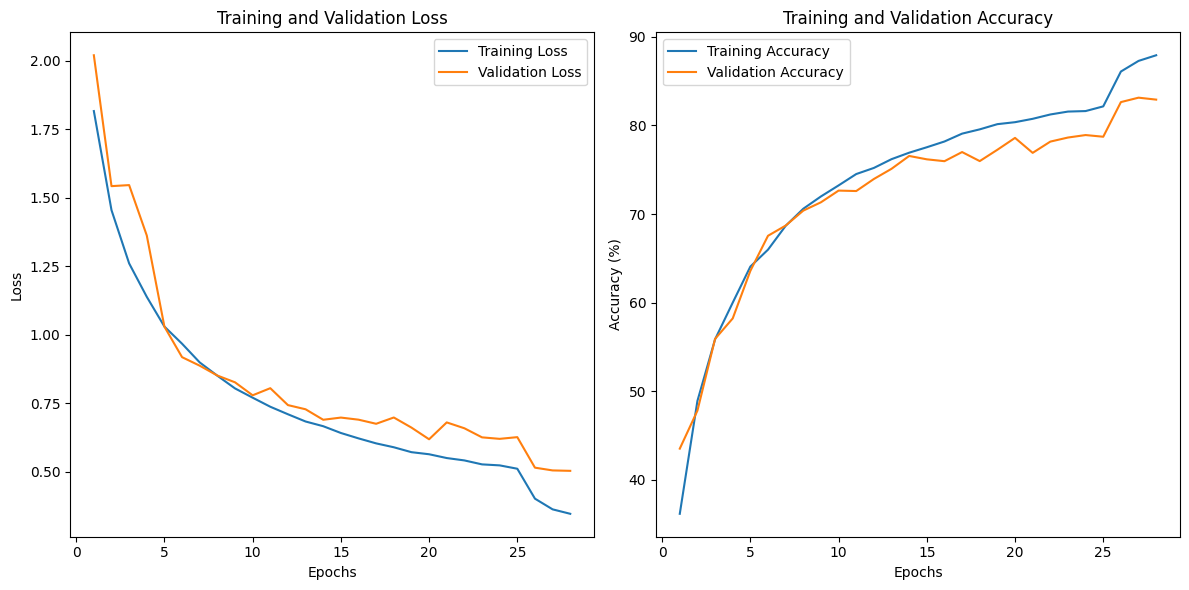

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
test_loss, test_accuracy = eval_epoch(model, criterion, testloader, device, test_mode=True)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4923, Test Accuracy: 83.49%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

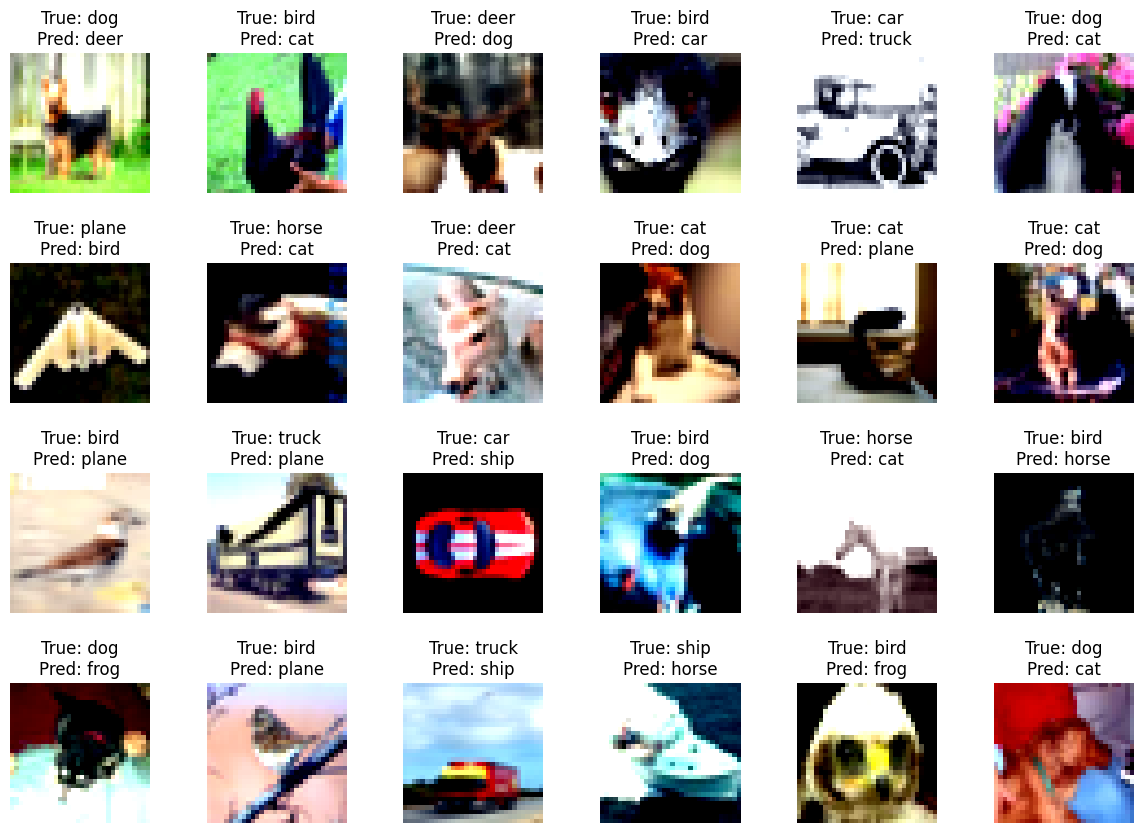

In [ ]:
model.eval()

def unnormalize(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    return np.transpose(npimg, (1, 2, 0))

incorrect_samples = []
incorrect_labels = []
predicted_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        mask = predicted != labels

        if len(incorrect_samples) < 24:
            for i in range(64):
                if mask[i]:
                    incorrect_samples.append(images[i].cpu())
                    incorrect_labels.append(labels[i].cpu())
                    predicted_labels.append(predicted[i].cpu())
                if len(incorrect_samples) == 24:
                    break
        else:
            break

fig, axs = plt.subplots(4, 6, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i, ax in enumerate(axs.flat):
    ax.imshow(unnormalize(incorrect_samples[i]))
    ax.set_title(f'True: {classes[incorrect_labels[i]]}\nPred: {classes[predicted_labels[i]]}')
    ax.axis('off')

plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
class ResNet18Features(ResNet18):
    def forward(self, x: torch.Tensor):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_activation(x)
        x = self.initial_pool(x)

        x = self.layer_block1(x)
        x = self.layer_block2(x)
        x = self.layer_block3(x)
        x = self.layer_block4(x)

        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        return x

feature_extractor = ResNet18Features(channels_img=3, num_classes=10).to(device)
feature_extractor.load_state_dict(model.state_dict())
feature_trainloader = DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)
features = torch.zeros((len(trainset), 512))

feature_extractor.eval()
with torch.no_grad():
    start_idx = 0
    for inputs, _ in feature_trainloader:
        inputs = inputs.to(device)
        outputs = feature_extractor(inputs)

        end_idx = start_idx + outputs.size(0)
        features[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

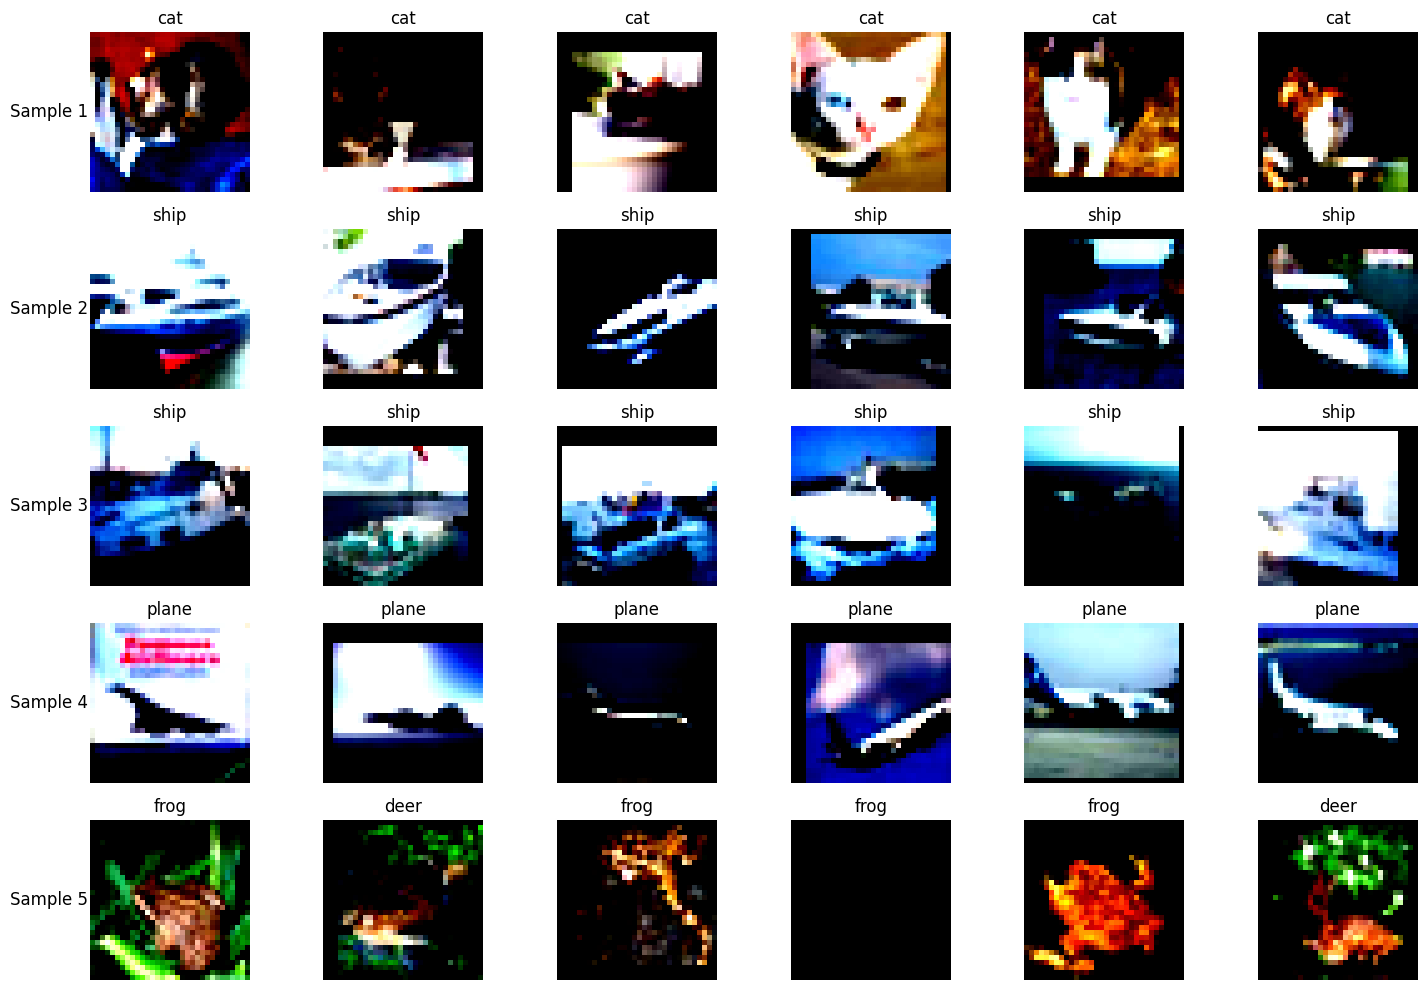

In [ ]:
feature_extractor.eval()
correct_samples = []
correct_features = []
correct_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = feature_extractor(inputs)
        _, predicted = torch.max(model(inputs), 1)

        mask = predicted == labels
        correct_indices = mask.nonzero(as_tuple=True)[0]

        for idx in correct_indices:
            correct_samples.append(inputs[idx].cpu())
            correct_features.append(outputs[idx].cpu())
            correct_labels.append(labels[idx].cpu())
            if len(correct_samples) == 5:
                break
        if len(correct_samples) == 5:
            break

correct_features = torch.stack(correct_features)
distances = torch.cdist(correct_features, features)
k = 5
_, indices = torch.topk(distances, k, largest=False, dim=1)

fig, axs = plt.subplots(5, k+1, figsize=(15, 10))
for i, (sample, label, nn_indices) in enumerate(zip(correct_samples, correct_labels, indices)):
    axs[i, 0].imshow(sample.permute(1, 2, 0).numpy())
    axs[i, 0].set_title(classes[label])
    axs[i, 0].axis('off')

    axs[i, 0].text(-0.5, 0.5, f'Sample {i+1}', transform=axs[i, 0].transAxes, fontsize=12, verticalalignment='center')

    for j, nn_idx in enumerate(nn_indices):
        neighbor_img, neighbor_label = trainset[nn_idx]
        axs[i, j+1].imshow(neighbor_img.permute(1, 2, 0).numpy())
        axs[i, j+1].set_title(classes[neighbor_label])
        axs[i, j+1].axis('off')

plt.tight_layout()
plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


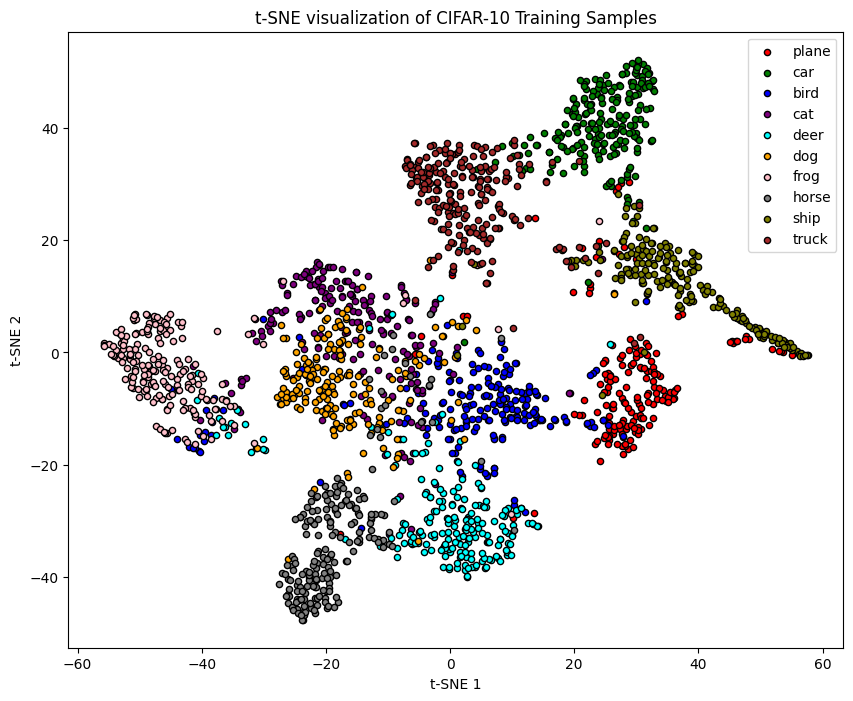

In [ ]:
M = 2000
N = features.size(1)
indices = torch.randperm(len(features))[:M]

sampled_features = features[indices]
sampled_labels = torch.tensor([trainset[i][1] for i in indices])
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(sampled_features)

colors = ['red', 'green', 'blue', 'purple', 'cyan', 'orange', 'pink', 'gray', 'olive', 'brown']

plt.figure(figsize=(10, 8))
for i in range(10):
    idxs = np.where(sampled_labels == i)
    plt.scatter(reduced_features[idxs, 0], reduced_features[idxs, 1], label=classes[i], c=colors[i], edgecolors='k', s=20)

plt.legend()
plt.title('t-SNE visualization of CIFAR-10 Training Samples')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [3]:
class BlackAndWhiteCIFAR10(Dataset):
  def __init__(self, root='./data', train=True, download=True, transform=None):
    self.cifarset = torchvision.datasets.CIFAR10(root=root, download=download, train=train, transform=transform)
    self.transform = transforms.Grayscale()

  def __len__(self):
    return len(self.cifarset)

  def __getitem__(self, index):
    img, _ = self.cifarset[index]
    return self.transform(img), img

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
initial_testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_size = int(0.8 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = random_split(initial_trainset, [train_size, val_size])

In [12]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

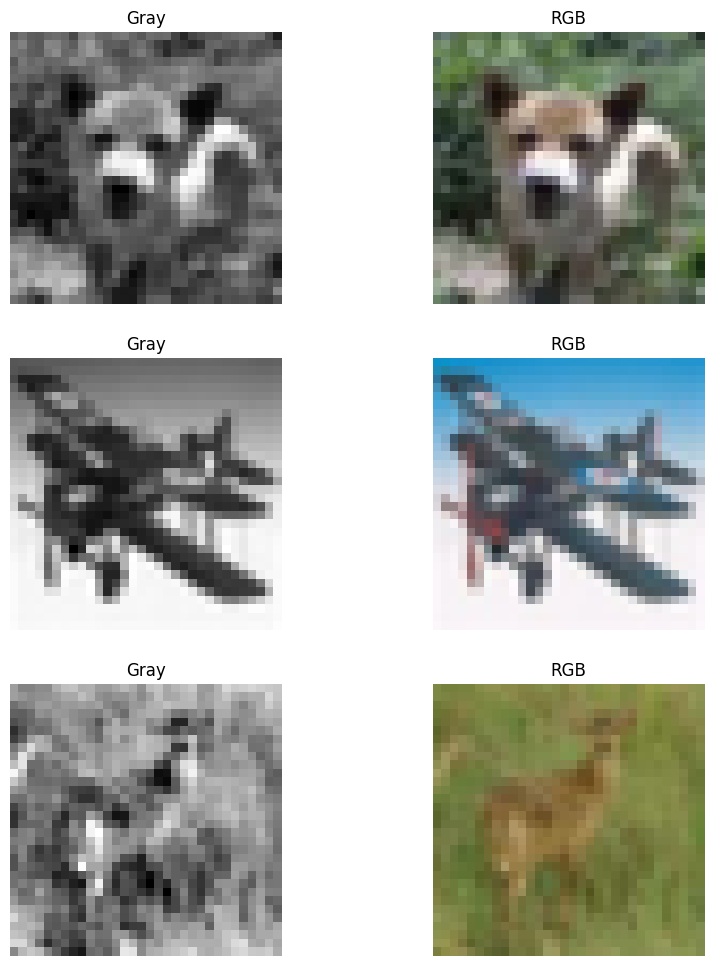

In [13]:
_, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 12))

for i in range(3):
    bw, rgb = trainset[i]

    axs[i, 0].imshow(bw.numpy()[0], cmap='gray')
    axs[i, 0].set_title('Gray')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(rgb.numpy().transpose(1, 2, 0))
    axs[i, 1].set_title('RGB')
    axs[i, 1].axis('off')

plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_batchnorm=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not use_batchnorm)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super(TransConvBlock, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=not use_batchnorm)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.batchnorm(self.transconv(x)))

class colorizationNet(nn.Module):
    def __init__(self):
        super(colorizationNet, self).__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)

        self.dec1 = TransConvBlock(512, 256)
        self.dec2 = TransConvBlock(256, 128)
        self.dec3 = TransConvBlock(128, 64)
        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        dec1 = self.dec1(enc4)
        dec2 = self.dec2(dec1)
        dec3 = self.dec3(dec2)
        dec4 = self.final(dec3)
        return torch.sigmoid(dec4)

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [25]:
net = colorizationNet().to(device)
print(net)

colorizationNet(
  (enc1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (d

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [27]:
def train_epoch(net, criterion, optimizer, dataloader):
    net.train()
    running_loss = 0.0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
#         print(inputs.shape, outputs.shape, targets.shape)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Train Loss: {epoch_loss:.4f}')
    return epoch_loss


def eval_epoch(net, criterion, dataloader, test_mode=False):
    if test_mode:
        net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'{"Test" if test_mode else "Validation"} Loss: {epoch_loss:.4f}')
    return epoch_loss


In [28]:
train_losses = []
val_losses = []

In [29]:
epochs = 35

for e in range(epochs):
    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader, test_mode=False)
    # scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {e + 1}")
#     print(f'Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    print("-" * 25)


Train Loss: 0.0126
Validation Loss: 0.0096
Epoch 1
-------------------------
Train Loss: 0.0093
Validation Loss: 0.0088
Epoch 2
-------------------------
Train Loss: 0.0086
Validation Loss: 0.0088
Epoch 3
-------------------------
Train Loss: 0.0082
Validation Loss: 0.0082
Epoch 4
-------------------------
Train Loss: 0.0079
Validation Loss: 0.0081
Epoch 5
-------------------------
Train Loss: 0.0077
Validation Loss: 0.0076
Epoch 6
-------------------------
Train Loss: 0.0075
Validation Loss: 0.0076
Epoch 7
-------------------------
Train Loss: 0.0073
Validation Loss: 0.0075
Epoch 8
-------------------------
Train Loss: 0.0072
Validation Loss: 0.0073
Epoch 9
-------------------------
Train Loss: 0.0070
Validation Loss: 0.0074
Epoch 10
-------------------------
Train Loss: 0.0069
Validation Loss: 0.0072
Epoch 11
-------------------------
Train Loss: 0.0069
Validation Loss: 0.0072
Epoch 12
-------------------------
Train Loss: 0.0067
Validation Loss: 0.0072
Epoch 13
---------------------

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

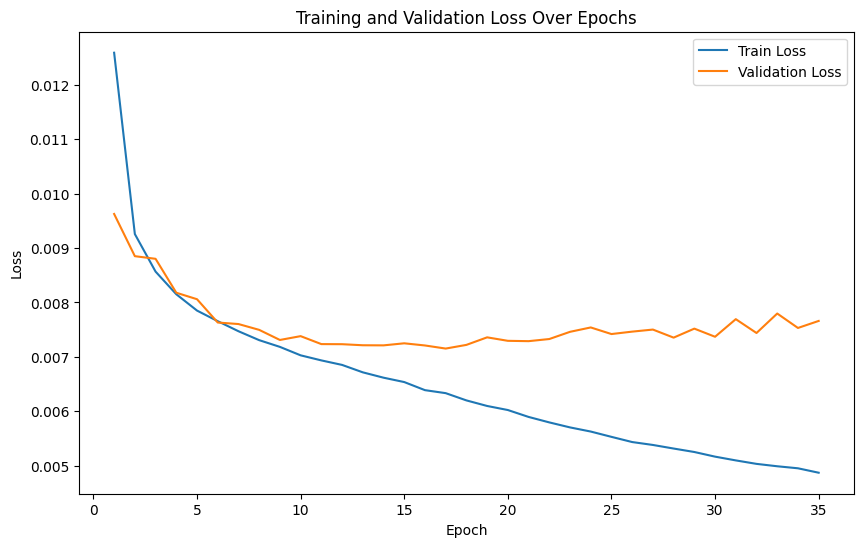

In [30]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



Files already downloaded and verified


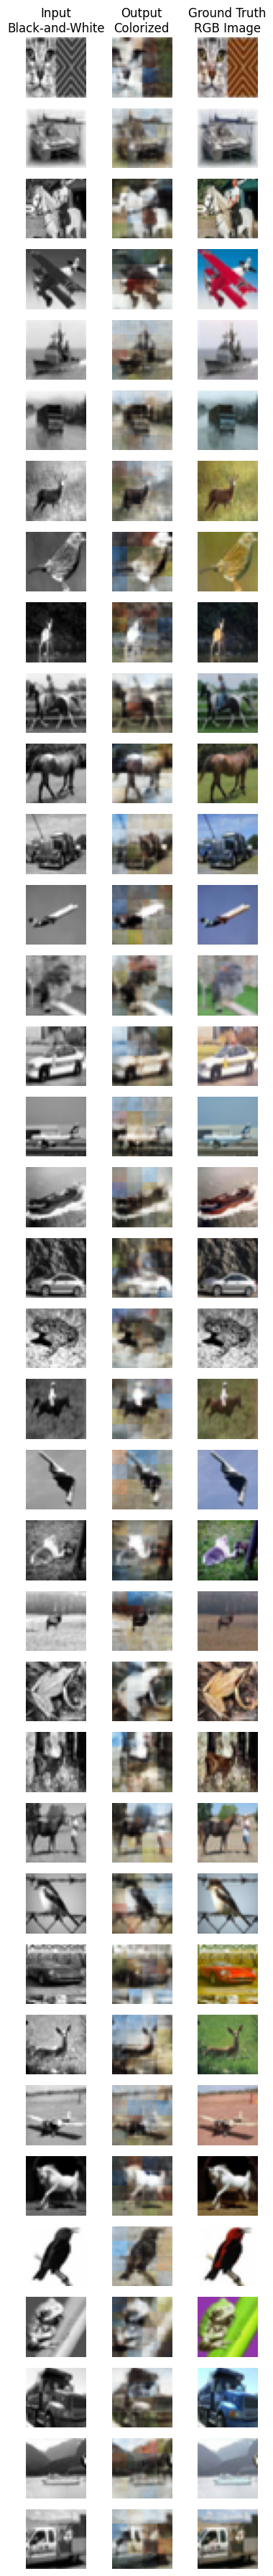

In [31]:
def visualize_results(dataset, model, num_samples=36):
    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(4, num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            bw_img, rgb_img = dataset[idx]
            bw_img = bw_img.unsqueeze(0).to(device)
            output = model(bw_img).cpu().squeeze(0)

            bw_img_denorm = bw_img.squeeze(0).cpu()
            rgb_img_denorm = rgb_img
            output_denorm = output

            axs[i, 0].imshow(bw_img_denorm.permute(1, 2, 0), cmap='gray')
            axs[i, 0].axis('off')
            if i == 0:
                axs[i, 0].set_title('Input\nBlack-and-White')

            axs[i, 1].imshow(output_denorm.permute(1, 2, 0).clamp(0, 1))
            axs[i, 1].axis('off')
            if i == 0:
                axs[i, 1].set_title('Output\nColorized')

            axs[i, 2].imshow(rgb_img_denorm.permute(1, 2, 0))
            axs[i, 2].axis('off')
            if i == 0:
                axs[i, 2].set_title('Ground Truth\nRGB Image')

    plt.tight_layout()
    plt.show()

test_dataset = BlackAndWhiteCIFAR10(root='./data', train=False, download=True, transform=transform_test)
visualize_results(test_dataset, net, num_samples=36)